## Optimizing Model Complexity

In [3]:
import numpy as np
import pandas as pd
from math import pi,exp

import matplotlib.pyplot as plt
%matplotlib inline

### Load the Data

Read the training data from file ex1-data-train.csv. The first two columns are x1 and x2. The last column holds the class label y. Compose suitable numpy array structures.

In [4]:
trainset = pd.read_csv('scores_train_2.csv',names=['x1','x2','y'])
testset = pd.read_csv('scores_test_2.csv',names=['x1','x2','y'])
testset.head()

,x1,x2,y
0,39.196334,78.530294,0
1,40.448499,86.839470,1
2,65.571920,44.303497,0
3,79.648113,70.806564,1
4,66.260221,41.672703,0


In [5]:
x1 = np.array(trainset['x1'].values)
x2 = np.array(trainset['x2'].values)
m = x1.size
x_train0 = np.concatenate([x1,x2],axis=0).reshape(2,m)
y_train = np.array(trainset['y'].values).reshape(1,m)

x1 = np.array(testset['x1'].values)
x2 = np.array(testset['x2'].values)
x_test0 = np.concatenate([x1,x2],axis=0).reshape(2,m)
y_test = np.array(testset['y'].values).reshape(1,m)

print("Training Set: ", x_train0.shape, y_train.shape)
print("Test Set:     ", x_test0.shape, y_test.shape)

Training Set:  (2, 100) (1, 100)
Test Set:      (2, 100) (1, 100)


Plot the training data using a scatter plot.

In [6]:
def plot_dataset(x, y):
    n = x.shape[1]
    x1 = x[0,:].reshape(1,n)
    x2 = x[1,:].reshape(1,n)
    plot_data(x1,x2,y)
    
    
def plot_data(x1,x2,y):
    indices_pass = np.where(y==1)
    indices_fail = np.where(y==0)

    x1_pass = x1[indices_pass]
    x2_pass = x2[indices_pass]
    x1_fail = x1[indices_fail]
    x2_fail = x2[indices_fail]
    plt.scatter(x1_fail,x2_fail,marker='o',color='green',label='not admitted')
    plt.scatter(x1_pass,x2_pass,marker='x',color='red',label='admitted')
    plt.xlabel('Exam 1 score $x_1$')
    plt.ylabel('Exam 2 score $x_2$')
    plt.legend(bbox_to_anchor=(1.1, 1))
    axes = plt.gca()
    plt.show()

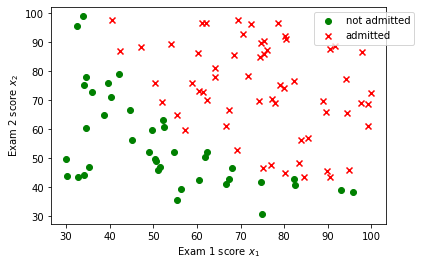

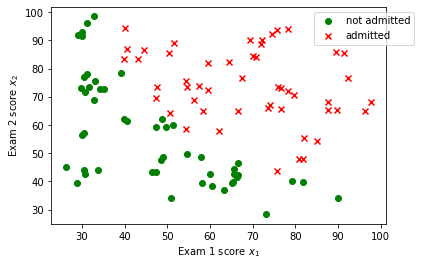

In [7]:
plot_dataset(x_train0, y_train)
plot_dataset(x_test0, y_test)

#### Normalize the Data

In [10]:
def normalize(X):
    ### START YOUR CODE
    mu = X.mean()
    std = X.std()
    
    X_norm = (X-mu)/std
    
    return X_norm, mu, std
    ### END YOUR CODE

In [11]:
x_train,mu,stdev = normalize(x_train0)
x_test = (x_test0-mu)/stdev

### Dummy Predictor

Dummy recognition system that takes decisions randomly.

In [12]:
def dummy_predictor(x):
    rnd = np.random.uniform(size=(1,x.shape[1]))
    return np.round(rnd)

In [13]:
def pass_rate(x):
    n_pass = np.sum(dummy_predictor(x_train))
    rate = n_pass/x_train.shape[1]
    return rate

Compute the performance $N_{correct}/N$ of this system on the test set ex1-data-train.csv, with $N$ the number of test samples and $N_{correct}$ the number of correct decision in comparison to the ground truth. This dummy recognition system should have a performance of \~50%

In [14]:
print(pass_rate(x_train.shape[1]))

0.59


In [15]:
performance_check = [pass_rate(x_train) for i in range(1000)]
print(np.mean(performance_check))

0.49879


### Modelling

We consider different models of different complexities involving different number of parameters. All these models involve combinations of powers in $x_1,x_2$ and are of the form

$\quad g(x_1,x_2) = \sigma(h(x_1,x_2)), \quad h(x_1,x_2)=\sum_{k=0}^n w_k \phi_k(x_1,x_2)$

with $\phi_k$  multinomials in $x_1,x_2$ (i.e. combinations of powers in $x_1,x_2$). The decision boundary is then given by $h(x_1,x_2)=0$. This can be formulated by a linear model of the form $\mathbf{W}\cdot\mathbf{x}$ by adding different dimensions to the input data with suitable powers of the prime input data $x_1,x_2$.

Specifically, we consider the following situations:

* Linear Affine: $h(x_1,x_2) = b_0 + w_1x_1 + w_2x_2$ where $\mathbf{x}=(1,x_1,x_2)$

* Quadratic: $h_2(x_1,x_2) = b_0 + w_1x_1 + w_2x_2 + w_3x_3 + w_4x_4 + w_5x_5$ where $\mathbf{x}=(1,x_1,x_2,x_1^2,x_2^2,x_1x_2)$

* etc.

All the above models are linear in the parameters. We can use the same optimisation function.

The method `polynomial_features` below will help you to extend the input dataset by additional dimensions up to a given polynomial order.

In [16]:
def polynomial_features(x, order):
    """
    Arguments:
    x -- input data as numpy array of shape (2,m) where m is the number of samples
    order -- the max order of terms to be added (x1^j*x2^i and i+j<=order)
    
    Returns:
    numpy array of shape (n,m) where n = (order+1)*(order+2)/2 (all the monomials x1^j*x2^i and i+j<=order)
    """
    m = x.shape[1]
    x1,x2 = x[0,:].reshape(1,m),x[1,:].reshape(1,m)
    features = np.concatenate([np.ones((m),dtype='float').reshape(1,m),x1,x2]).reshape(3,m)
    n = 3
    if order > 1:
        for i in range(2,order+1):
            for term in range(i+1):
                features = np.append(features, (x1**(i-term)*x2**term).reshape(1,m), axis=0)
                n += 1
    return features

### Predict, Optimize

In [17]:
def initialize_weights(n):
    return np.random.normal(size=(1,n))*0.01

In [19]:
# Auxiliary methods suited for performing the optimize-step below

def predict(X,W):
    """
    Computes the predicted value - given the inpute feature matrix of shape (n,m) and weights vector of shape (1,n).
    The number of features n also includes the bias term.
    """
    ### START YOUR CODE
    h = W.dot(X)
    out = 1/ (1+np.exp(h))
    
    return out
    ### END YOUR CODE
    
def cost(A,Y):
    """
    Computes cross-entropy cost.
    
    Arguments:
    A -- Activations
    Y -- Labels
    """
    m = Y.shape[1]
    c = -np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))/m
    return c

def error_rate(A, Y):
    """
    Computes the error rate.

    Arguments:
    A -- Activations
    Y -- Labels
    """
    Ypred = np.round(A)
    return np.sum(Y != Ypred) / Y.size

def gradient_cost(A,X,Y):
    """
    Computes the gradient for the cost with respect to the weights vector of size (1,n)
    
    Arguments:
    A -- Activations of shape (1,m)
    X -- Input of shape (n,m)
    Y -- Labels of shape (1,m)
    
    Returns:
    Vector of shape (n,m)
    """
    ### START YOUR CODE
    grad = (Y-A).dot(X.T)
    return grad
    ### END YOUR CODE

In [37]:
def optimize(Xtrain,Ytrain,Xtest,Ytest,nepochs,learningrate, batch_size=128):
    """
    Implements (batch) gradient descent for minimizing cross-entropy cost. It returns the learning curves 
    for cost and error rate (test and training). The curves are returned as numpy array of lenghth nepochs+1 
    (the +1 for the initial values).  
    
    Arguments:
    Xtrain -- input data for training, numpy array with shape (n,m)
    Ytrain -- labels for training, numpy array with shape (1,m)
    Xtest -- input data for test, numpy array with shape (n,m)
    Ytest -- labels for test, numpy array with shape (1,m)
    nepochs -- number of epochs
    learningrate -- learning rate
    
    Returns:
    traincosts -- learning curve with the cost on the training dataset, a numpy array of shape (nepochs+1)
    testcosts -- learning curve with the cost on the test dataset, a numpy array of shape (nepochs+1) 
    trainerror -- learning curve with the error rate on the training dataset, a numpy array of shape (nepochs+1)
    testerror -- learning curve with the error rate on the test dataset, a numpy array of shape (nepochs+1)
    W -- parameter vector, a numpy array of shape (1,n+1)
    """
    ### START YOUR CODE
    n = Xtrain.shape[0]
    m = Xtrain.shape[1]
    
    W = np.random.normal(0, 1, (1, n))
    
    indices = np.arange(0, m)
    
    train_costs = []
    train_errors = []
    test_costs = []
    test_errors = []
    
    batches_per_epoch = m // batch_size
    
    for i in range(nepochs):
        for j in range(batches_per_epoch):
            batch = np.random.choice(indices, batch_size)
            
            xbatch = Xtrain[:, batch]
            ybatch = Ytrain[:, batch]
            
            pred = predict(xbatch, W)
            
            W -= learningrate * gradient_cost(pred, xbatch, ybatch)
            
        trainpred = predict(Xtrain, W)
        
        train_costs.append(cost(trainpred, Ytrain))
        train_errors.append(error_rate(trainpred, Ytrain))
        
        testpred = predict(Xtest, W)
        test_costs.append(cost(testpred, Ytest))
        test_errors.append(error_rate(testpred, Ytest))
        
    return np.array(train_costs), np.array(test_costs), np.array(train_errors), np.array(test_errors), W
    
    ### END YOUR CODE

In [32]:
def evaluate(x_train,y_train,x_test,y_test,pol_degree, nepochs, learningrate):
    """
    Evaluate a model by training it, plotting the learning curves and the decision boundary and 
    returning the performance (final cost and error rate obtained for training and test set)
    """
    Xtrain = polynomial_features(x_train, pol_degree)
    Xtest = polynomial_features(x_test,pol_degree)
    traincosts, testcosts, trainerror, testerror, W = optimize(Xtrain,y_train,Xtest,y_test,nepochs,learningrate)
    plot_curves(traincosts, testcosts, trainerror, testerror)
    Jtrain, Jtest, etrain, etest = traincosts[-1],testcosts[-1],trainerror[-1],testerror[-1]
    print(Jtrain, Jtest, etrain, etest)
    print(W)
    return Jtrain, Jtest, etrain, etest, W

In [33]:
def plot_curves(traincosts, testcosts, trainerror, testerror):
    iterations = range(traincosts.size)
    f = plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.plot(iterations, traincosts,label="train")
    plt.plot(iterations, testcosts, label="test")
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(iterations, trainerror, label="train")
    plt.plot(iterations, testerror, label="test")
    plt.ylabel('Error')
    plt.xlabel('Epochs')
    plt.show()

In [34]:
def plot_decision_boundary(x, y, W, pol_degree):
    x1 = x[0,:]
    x2 = x[1,:]
    indices_pass = np.where(y[0,:]==1)
    indices_fail = np.where(y[0,:]==0)

    x1_pass = x1[indices_pass]
    x2_pass = x2[indices_pass]
    x1_fail = x1[indices_fail]
    x2_fail = x2[indices_fail]

    f, ax = plt.subplots(figsize=(7, 7))
    ax.scatter(x1_fail,x2_fail,marker='o',color='green',label='not admitted')
    ax.scatter(x1_pass,x2_pass,marker='x',color='red',label='admitted')
    plt.xlabel('Exam 1 score $x_1$')
    plt.ylabel('Exam 2 score $x_2$')
    ax.legend(bbox_to_anchor=(1.1, 1))
    axes = plt.gca()

    x1_min, x1_max = x1.min() - 1, x1.max() + 1
    x2_min, x2_max = x2.min() - 1, x2.max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, (x1_max-x1_min)/100), np.arange(x2_min, x2_max, (x2_max-x2_min)/100))
    xx10 = xx1.reshape(1,xx1.size)
    xx20 = xx2.reshape(1,xx2.size)
    xx = np.concatenate((xx10, xx20), axis=0) 
    yy = W.dot(polynomial_features(xx, pol_degree)).reshape(xx1.shape)
    
    ax.contour(xx1, xx2, yy, levels=[0], cmap=plt.cm.Paired)
    #ax.axis('off')

    plt.show()
    

### Evaluate the different models

Evaluate different polynomial models of the form as described above (starting with linear of order=1, then proceeding to quadratic of order=2 and to higher order models).

Use the "evaluate" function above that will provide also some diagnostic plot. Carefully tune the inputs such as the nepcohs and learning rate - do this for each selected model. Inspect the learning curves to judge whether the training has converged.

Remember the error rates for training set and test for the different models and create a plot showing the error rates at different model complexity.

Describe what you observe.


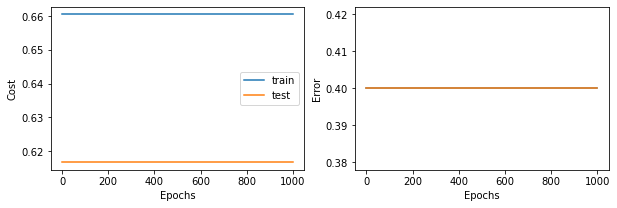

0.6605966156112703 0.616694858594375 0.4 0.4
[[ 0.56965131 -0.04341631 -0.6620216 ]]


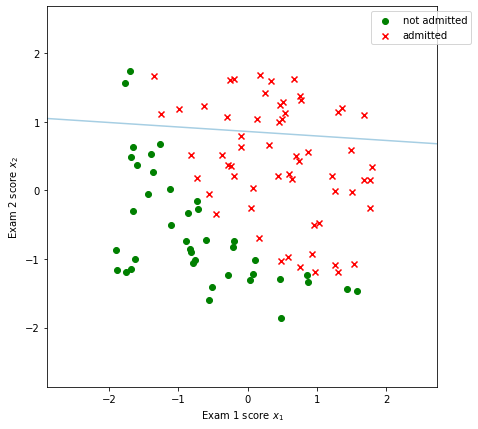

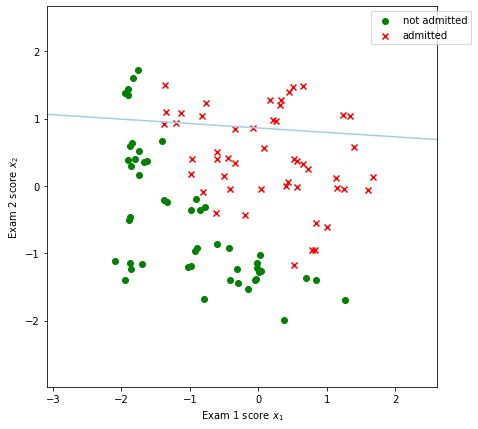

In [38]:
pol_degree = 1
nepochs = 1000
learningrate = 0.1

traincost1, testcost1, trainerror1, testerror1, W1 = evaluate(x_train,y_train,x_test,y_test,pol_degree, nepochs, learningrate)
plot_decision_boundary(x_train, y_train, W1, pol_degree)
plot_decision_boundary(x_test, y_test, W1, pol_degree)
